
# **MTA Bus Automated Camera Enforcement Violations Beginning October 2019 - 2025**

## Team Group: Raymond, Sam, Daniel, Osman

*The purpose of this analyzing ACE dataset is to evaluate whether automated camera enforcement offers improvements to bus services, identify pattern of violations,and estimate the impact of certain policies on bus services (congestion pricing).*

**Datasets That We Choose to Use**

Primary Datasets:

*   MTA Bus Route
*   ACE Violation Logs
*   Congestion Pricing Data

Supporting Datasets:

*   CUNY Campus Locations:
*   Weather & Traffic Conditions
*   Population/land-use maps

Cleaning & Prep:

*   Join bus route ridership with CUNY campus
*   Tag routes with ACE coverage and congestion zone overlap
*   Label exempt vs. non-exempt violation
*   Accumulate by time and geography.

# Task
Analyze the impact of ACE camera enforcement on bus speed and reliability for key bus routes serving CUNY students using the provided MTA datasets: MTA GTFS Static Data, MTA Bus Hourly Ridership (2020-2024, Beginning 2025), MTA ACE Enforced Routes, MTA Bus Route Segment Speeds (2023-2024, Beginning 2025), and MTA Bus Wait Assessment / Customer Journey-Focused Metrics. Geocode major CUNY campuses and identify nearby bus stops and high-ridership routes. Compare bus speeds and reliability on ACE-enforced routes before and after activation, using non-ACE routes as a control. Visualize the results on a map showing CUNY campuses, high-impact ACE routes, and speed improvements.

In [ ]:
cuny_campuses = {
    'Campus': [
        'Baruch College',
        'Hunter College',
        'City College of New York',
        'Brooklyn College',
        'Queens College',
        'Lehman College',
        'Staten Island College',
        'John Jay College of Criminal Justice',
        'BMCC (Borough of Manhattan Community College)',
        'Hostos Community College',
        'LaGuardia Community College',
        'Kingsborough Community College',
        'Queensborough Community College',
        'Bronx Community College',
        'New York City College of Technology (City Tech)',
        'CUNY Graduate Center',
        'CUNY School of Professional Studies',
        'CUNY School of Public Health'
    ],
    'Coordinates': [
        (40.7382, -73.9835), # Baruch College
        (40.7688, -73.9647), # Hunter College
        (40.8198, -73.9489), # City College of New York
        (40.6310, -73.9544), # Brooklyn College
        (40.7361, -73.8196), # Queens College
        (40.8737, -73.8941), # Lehman College
        (40.6129, -74.1516), # Staten Island College
        (40.7690, -73.9831), # John Jay College of Criminal Justice
        (40.7162, -74.0111), # BMCC
        (40.8171, -73.9268), # Hostos Community College
        (40.7438, -73.9340), # LaGuardia Community College
        (40.5788, -73.9344), # Kingsborough Community College
        (40.7646, -73.7774), # Queensborough Community College
        (40.8552, -73.9106), # Bronx Community College
        (40.6952, -73.9875), # City Tech
        (40.7535, -73.9832), # CUNY Graduate Center
        (40.7858, -73.9762), # CUNY School of Professional Studies
        (40.7529, -73.9701)  # CUNY School of Public Health
    ]
}

cuny_df = pd.DataFrame(cuny_campuses)
cuny_df

,Campus,Coordinates
0,Baruch College,"(40.7382, -73.9835)"
1,Hunter College,"(40.7688, -73.9647)"
2,City College of New York,"(40.8198, -73.9489)"
3,Brooklyn College,"(40.631, -73.9544)"
4,Queens College,"(40.7361, -73.8196)"
5,Lehman College,"(40.8737, -73.8941)"
6,Staten Island College,"(40.6129, -74.1516)"
7,John Jay College of Criminal Justice,"(40.769, -73.9831)"
8,BMCC (Borough of Manhattan Community College),"(40.7162, -74.0111)"
9,Hostos Community College,"(40.8171, -73.9268)"


**Reasoning**:
Load the stops data and define the radius for nearby stops. Then, iterate through each CUNY campus to find nearby bus stops within the defined radius and store them.



In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load bus stops from GTFS
stops = pd.read_csv('/content/gtfs_data/stops.txt')
stops['geometry'] = stops.apply(lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
stops_gdf = gpd.GeoDataFrame(stops, geometry='geometry', crs='EPSG:4326')

# Convert CUNY DataFrame to GeoDataFrame
cuny_df['geometry'] = cuny_df['Coordinates'].apply(lambda coord: Point(coord[1], coord[0]))  # lon, lat
cuny_gdf = gpd.GeoDataFrame(cuny_df, geometry='geometry', crs='EPSG:4326')

# Buffer campus points to 400 meters (~0.25 miles)
cuny_gdf = cuny_gdf.to_crs(epsg=2263)  # Project to feet for accurate buffer
cuny_gdf['buffer'] = cuny_gdf.geometry.buffer(1312)  # 400 meters ≈ 1312 feet
cuny_gdf = cuny_gdf.set_geometry('buffer')

# Reproject bus stops
stops_gdf = stops_gdf.to_crs(epsg=2263)

# Spatial join: find stops within 400 meters of each campus
joined = gpd.sjoin(stops_gdf, cuny_gdf, how='inner', predicate='within')
cuny_gdf['buffer'] = cuny_gdf.geometry.buffer(2625)

# Load other GTFS data
stop_times = pd.read_csv('/content/gtfs_data/stop_times.txt')
trips = pd.read_csv('/content/gtfs_data/trips.txt')
routes = pd.read_csv('/content/gtfs_data/routes.txt')

# Merge to get route_id for each stop
stop_route_map = stop_times.merge(trips, on='trip_id').merge(routes, on='route_id')

# Now filter for the stops near CUNY
cuny_stops = joined[['stop_id', 'Campus']].merge(stop_route_map, on='stop_id')

# Get unique routes per campus
cuny_bus_routes = cuny_stops[['Campus', 'route_short_name']].drop_duplicates()


print(cuny_gdf.crs, stops_gdf.crs)


EPSG:2263 EPSG:2263


In [ ]:
# Group bus routes per campus into a list, sorted alphabetically
grouped_routes = cuny_bus_routes.groupby('Campus')['route_short_name'] \
    .apply(lambda x: sorted(x.unique())) \
    .reset_index()

# Preview the result
grouped_routes


,Campus,route_short_name
0,BMCC (Borough of Manhattan Community College),"[M20, M22, M55, M9]"
1,Baruch College,"[M1, M101, M102, M103, M15, M15-SBS, M2, M23-S..."
2,CUNY Graduate Center,"[M1, M2, M3, M4, M42, M5, M55, M7]"
3,CUNY School of Professional Studies,"[M104, M11, M7, M79-SBS, M86-SBS]"
4,CUNY School of Public Health,"[M101, M102, M103, M15, M15-SBS, M42, M50]"
5,City College of New York,"[M10, M101, M11, M3]"
6,Hunter College,"[M1, M101, M102, M103, M2, M3, M4, M66, M72, M98]"
7,John Jay College of Criminal Justice,"[M10, M104, M11, M12, M20, M31, M5, M57, M7]"


In [ ]:
ace_violations_df = pd.read_csv('/content/MTA_Bus_Automated_Camera_Enforcement_Violations__Beginning_October_2019_20250919 (1).csv')

# Clean and extract route names from ACE data
ace_routes_from_violations = ace_violations_df['Bus Route ID'].dropna().str.strip().unique()

# -------------------------------
# 8. Add ACE tags to grouped routes
# -------------------------------
# List of ACE routes for each campus
grouped_routes['ACE Enforced Routes'] = grouped_routes['route_short_name'].apply(
    lambda routes: [route for route in routes if route in ace_routes_from_violations]
)

# Boolean flag if any ACE route is present
grouped_routes['Has ACE Enforcement'] = grouped_routes['ACE Enforced Routes'].apply(lambda x: len(x) > 0)

# -------------------------------
# 9. Optional: Format for Display
# -------------------------------
grouped_routes['Nearby Routes'] = grouped_routes['route_short_name'].apply(lambda x: ', '.join(x))
grouped_routes['ACE Enforced Routes'] = grouped_routes['ACE Enforced Routes'].apply(lambda x: ', '.join(x))

# Drop raw list if desired
grouped_routes_final = grouped_routes[['Campus', 'Nearby Routes', 'ACE Enforced Routes', 'Has ACE Enforcement']]

# -------------------------------
# 10. Display Final Output
# -------------------------------
display(grouped_routes_final)

,Campus,Nearby Routes,ACE Enforced Routes,Has ACE Enforcement
0,BMCC (Borough of Manhattan Community College),"M20, M22, M55, M9",,False
1,Baruch College,"M1, M101, M102, M103, M15, M15-SBS, M2, M23-SB...","M101, M2",True
2,CUNY Graduate Center,"M1, M2, M3, M4, M42, M5, M55, M7","M2, M4, M42",True
3,CUNY School of Professional Studies,"M104, M11, M7, M79-SBS, M86-SBS",,False
4,CUNY School of Public Health,"M101, M102, M103, M15, M15-SBS, M42, M50","M101, M42",True
5,City College of New York,"M10, M101, M11, M3",M101,True
6,Hunter College,"M1, M101, M102, M103, M2, M3, M4, M66, M72, M98","M101, M2, M4",True
7,John Jay College of Criminal Justice,"M10, M104, M11, M12, M20, M31, M5, M57, M7",,False


In [ ]:
import pandas as pd

# Load the bus speeds data file
file_path = '/content/MTA_Bus_Speeds__2020_-_2024_20250924.csv'

# Load the data, using the column names provided by the user, including 'month'
relevant_cols = ['route_id', 'period', 'total_mileage', 'total_operating_time', 'average_speed', 'month'] # Using 'month' for filtering
bus_speeds_df = pd.read_csv(file_path, usecols=relevant_cols)

# Convert 'month' to datetime, specifying the format
# Assuming the format is 'YYYY-MM-DD' based on '2020-01-0' example (though '0' might be '01')
# Let's try a few common formats or infer, but specifying is better if known precisely.
# Based on '2020-01-0', a format like '%Y-%m-%d' might work if the last digit is sometimes missing or single digit.
# Let's assume it's '%Y-%m-%d' and coerce errors.
bus_speeds_df['date'] = pd.to_datetime(bus_speeds_df['month'], format='%Y-%m-%d', errors='coerce')

# Filter data for years 2020 to 2023 using the new 'date' column
bus_speeds_df_filtered = bus_speeds_df[(bus_speeds_df['date'].dt.year >= 2020) & (bus_speeds_df['date'].dt.year <= 2023)].copy()

print(f"Data filtered for years 2020 to 2023 using 'month' column. Number of rows: {len(bus_speeds_df_filtered)}")

# Calculate the average speed for each bus route using the specified column names
average_speed_by_route = bus_speeds_df_filtered.groupby('route_id')['average_speed'].mean().reset_index()

print(f"\nAverage bus speed (MPH) by route from {file_path} for years 2020-2023:")
display(average_speed_by_route)

Data filtered for years 2020 to 2023 using 'month' column. Number of rows: 760

Average bus speed (MPH) by route from /content/MTA_Bus_Speeds__2020_-_2024_20250924.csv for years 2020-2023:


,route_id,average_speed
0,M101,6.519604
1,M2,7.192207
2,M4,6.266718
3,M42,5.251036


In [ ]:
import pandas as pd

# Assuming average_speed_by_route (for 2020-2023) is available from cell EnWfbarEN4m9

# Load the bus speeds data for 2023-2024
file_path_2023_2024 = '/content/MTA_Bus_Route_Segment_Speeds__2023_-_2024_20250924.csv'

# Load the data, assuming 'Route ID', 'Average Road Speed' and 'Timestamp' are relevant
relevant_cols = ['Route ID', 'Timestamp', 'Average Road Speed']
bus_speeds_df_2023_2024 = pd.read_csv(file_path_2023_2024, usecols=relevant_cols)

# Convert 'Timestamp' to datetime
bus_speeds_df_2023_2024['Timestamp'] = pd.to_datetime(bus_speeds_df_2023_2024['Timestamp'], errors='coerce')

# Filter data for years 2023 and 2024
bus_speeds_df_2023_2024_filtered = bus_speeds_df_2023_2024[
    (bus_speeds_df_2023_2024['Timestamp'].dt.year >= 2023) &
    (bus_speeds_df_2023_2024['Timestamp'].dt.year <= 2024)
].copy()

# Calculate the average speed for each bus route for 2023-2024
average_speed_by_route_2023_2024 = bus_speeds_df_2023_2024_filtered.groupby('Route ID')['Average Road Speed'].mean().reset_index()
average_speed_by_route_2023_2024.rename(columns={'Average Road Speed': 'Average Speed (2023-2024)'}, inplace=True)

print("\nAverage bus speed (MPH) by route from 2023-2024 data:")
display(average_speed_by_route_2023_2024)

# Compare with 2020-2023 average speeds
# Check if 2020-2023 averages are available
if 'average_speed_by_route' in locals():
    comparison_df = pd.merge(
        average_speed_by_route, # 2020-2023 averages
        average_speed_by_route_2023_2024, # 2023-2024 averages
        left_on='route_id', # Assuming 'route_id' is the column name in 2020-2023 data
        right_on='Route ID', # Assuming 'Route ID' is the column name in 2023-2024 data
        how='outer' # Use outer merge to include all routes from both periods
    )

    # Drop the redundant 'Route ID' column from the merge
    comparison_df.drop(columns=['Route ID'], inplace=True)
    comparison_df.rename(columns={'route_id': 'Route ID'}, inplace=True) # Rename the route ID column for clarity

    # Calculate percentage change
    comparison_df['Percentage Change (2020-2023 to 2023-2024)'] = (
        (comparison_df['Average Speed (2023-2024)'] - comparison_df['average_speed']) / comparison_df['average_speed']
    ) * 100

    print("\nComparison of Average Bus Speed (MPH) and Percentage Change (2020-2023 vs 2023-2024):")
    display(comparison_df)

else:
    print("\nAverage speed data for 2020-2023 not found. Cannot perform comparison.")


Average bus speed (MPH) by route from 2023-2024 data:


,Route ID,Average Speed (2023-2024)
0,M101,7.388023
1,M2,8.075144
2,M4,6.349652
3,M42,5.482560



Comparison of Average Bus Speed (MPH) and Percentage Change (2020-2023 vs 2023-2024):


,Route ID,average_speed,Average Speed (2023-2024),Percentage Change (2020-2023 to 2023-2024)
0,M101,6.519604,7.388023,13.320128
1,M2,7.192207,8.075144,12.276303
2,M4,6.266718,6.349652,1.323408
3,M42,5.251036,5.482560,4.409105


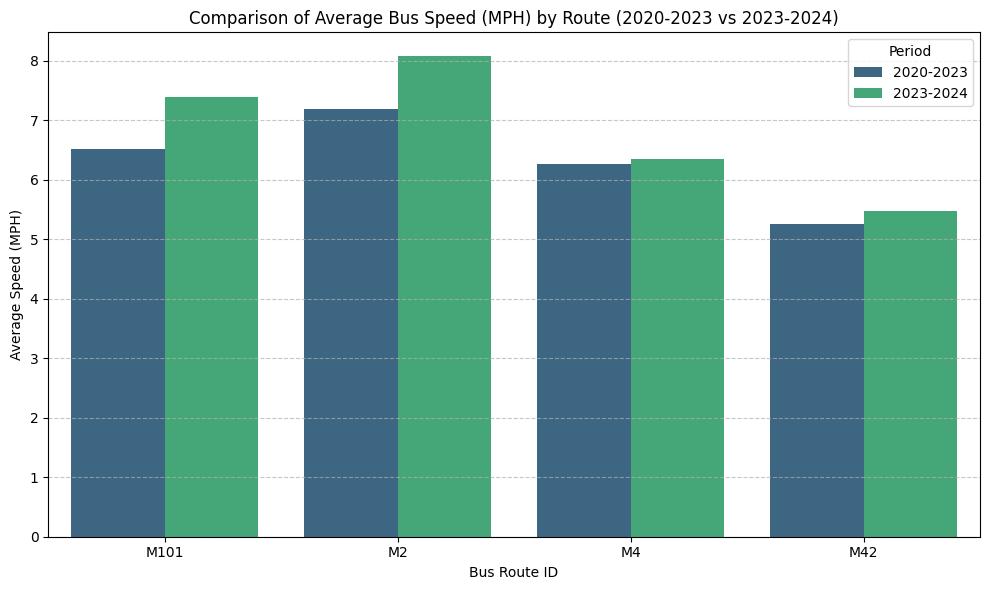

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming comparison_df is available from the previous cell
# Ensure the DataFrame is not empty and has the necessary columns
if not comparison_df.empty and 'Route ID' in comparison_df.columns and 'average_speed' in comparison_df.columns and 'Average Speed (2023-2024)' in comparison_df.columns:

    # Melt the DataFrame for easier plotting with seaborn
    melted_speeds = comparison_df.melt(
        id_vars='Route ID',
        value_vars=['average_speed', 'Average Speed (2023-2024)'],
        var_name='Period',
        value_name='Average Speed (MPH)'
    )

    # Rename the 'Period' values for better labels
    melted_speeds['Period'] = melted_speeds['Period'].replace({
        'average_speed': '2020-2023',
        'Average Speed (2023-2024)': '2023-2024'
    })

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=melted_speeds, x='Route ID', y='Average Speed (MPH)', hue='Period', palette='viridis')

    plt.title('Comparison of Average Bus Speed (MPH) by Route (2020-2023 vs 2023-2024)')
    plt.xlabel('Bus Route ID')
    plt.ylabel('Average Speed (MPH)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Period')
    plt.tight_layout()
    plt.show()
else:
    print("Comparison DataFrame is not available or does not contain the required columns for plotting.")

#TASK 2
Find patterns in violations from exempt vehicles (government, diplomatic plates) and identify geographic hotspots.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# load the MTA ACE data set
file_path =  "/content/MTA_Bus_Automated_Camera_Enforcement_Violations__Beginning_October_2019_20250922 (Filtered).csv"
df = pd.read_csv(file_path)

# 1. Count violations grouped by (Violation Status, Violation Type)
violation_counts = (df.groupby(["Violation Status", "Violation Type"]).size().to_dict())

# 2. Sort dictionary items by count(descending)
sorted_violations = sorted(violation_counts.items(), key=lambda x: x[1], reverse=True)

# 3. Extract the Top 10
top_10_offenders = sorted_violations[:10]

# 4. Print the result of the findings
print("Dictoionary of count (first 5):", dict(list(violation_counts.items())[:5]))
for (status, vtype), count in top_10_offenders:
  print(f"{status} - {vtype}: {count}")

Dictoionary of count (first 5): {('DRIVER/VEHICLE INFO MISSING', 'MOBILE BUS LANE'): 87338, ('DRIVER/VEHICLE INFO MISSING', 'MOBILE BUS STOP'): 89359, ('DRIVER/VEHICLE INFO MISSING', 'MOBILE DOUBLE PARKED'): 94014, ('EXEMPT - BUS/PARATRANSIT', 'MOBILE BUS LANE'): 93866, ('EXEMPT - BUS/PARATRANSIT', 'MOBILE BUS STOP'): 57675}
VIOLATION ISSUED - MOBILE BUS LANE: 750530
VIOLATION ISSUED - MOBILE BUS STOP: 741703
VIOLATION ISSUED - MOBILE DOUBLE PARKED: 706082
EXEMPT - COMMERCIAL UNDER 20 - MOBILE DOUBLE PARKED: 204282
EXEMPT - EMERGENCY VEHICLE - MOBILE BUS LANE: 117218
TECHNICAL ISSUE/OTHER - MOBILE BUS LANE: 114075
TECHNICAL ISSUE/OTHER - MOBILE BUS STOP: 103948
EXEMPT - EMERGENCY VEHICLE - MOBILE BUS STOP: 101436
TECHNICAL ISSUE/OTHER - MOBILE DOUBLE PARKED: 100717
DRIVER/VEHICLE INFO MISSING - MOBILE DOUBLE PARKED: 94014


First Occurrence    datetime64[ns]
Last Occurrence     datetime64[ns]
Violation Status            object
dtype: object


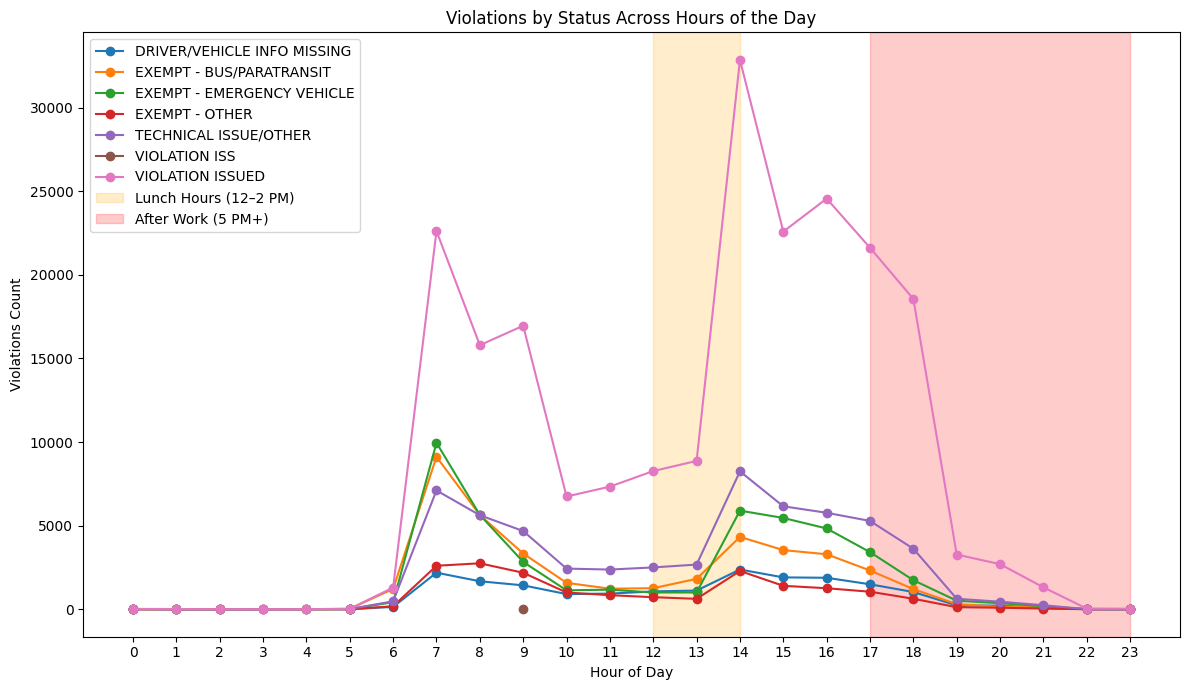

In [ ]:
import matplotlib.pyplot as plt
# 1. Load the dataset
file_path = "/content/MTA_Bus_Automated_Camera_Enforcement_Violations__Beginning_October_2019_20250922(Violations Status).csv"

# 2. Read CSV, forcing violation type to string
violation_df = pd.read_csv(file_path, dtype={"Violation Status": str})

# 3. Convert to datetime explicitly
violation_df["First Occurrence"] = pd.to_datetime(violation_df["First Occurrence"], errors="coerce")
violation_df["Last Occurrence"] = pd.to_datetime(violation_df["Last Occurrence"], errors="coerce")

# 4. Verify dtypes
print(violation_df.dtypes)

# 5. Extract the hour from the first occurrence
violation_df["hour"] = violation_df["First Occurrence"].dt.hour

# 6. Group by violation type + hour
hourly_counts = (violation_df.groupby(["Violation Status", "hour"]).size().reset_index(name="count"))

# ---- Plotting ----
plt.figure(figsize=(12,7))

for violation_status in hourly_counts["Violation Status"].unique():
    subset = hourly_counts[hourly_counts["Violation Status"] == violation_status]
    plt.plot(subset["hour"], subset["count"], marker="o", label=violation_status)

# 7. Highlight lunch hours (12–14) and after 5 PM (17+)
plt.axvspan(12, 14, color="orange", alpha=0.2, label="Lunch Hours (12–2 PM)")
plt.axvspan(17, 23, color="red", alpha=0.2, label="After Work (5 PM+)")

# 8. Labels & Title
plt.xticks(range(0,24))
plt.xlabel("Hour of Day")
plt.ylabel("Violations Count")
plt.title("Violations by Status Across Hours of the Day")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import requests
import json
bus_lane_url= "https://data.cityofnewyork.us/resource/ycrg-ses3.json"
get_bus_lane_url = requests.get(bus_lane_url, params={"$limit": 3})
sample = get_bus_lane_url.json()
print(json.dumps(sample, indent=2)[:1000])

[
  {
    "the_geom": {
      "type": "MultiLineString",
      "coordinates": [
        [
          [
            -73.96796054798135,
            40.68372681250015
          ],
          [
            -73.9668896223823,
            40.68348273118454
          ]
        ]
      ]
    },
    "street": "FULTON STREET",
    "bltrafdir": "T",
    "segmentid": "0029245",
    "rw_type": "1",
    "streetwidt": "0.0",
    "boro": "BK",
    "facility": "Fulton Street",
    "direction": "WB",
    "hours": "7AM-10AM",
    "days": "Mon - Fri",
    "days_code": "5.0",
    "lane_width": "Single",
    "lane_type1": "Shared Lane",
    "lane_type": "Curbside",
    "open_dates": "06/01/2018",
    "year1": "2018",
    "year2": "0",
    "year3": "0",
    "last_updat": "2/25/2019",
    "chron_id_1": "BK2018",
    "shape_leng": "310.046436532",
    "shape_le_1": {
      "type": "MultiLineString",
      "coordinates": [
        [
          [
            993136.0940925032,
            188378.16397592425
      

In [ ]:
import geopandas as gpd
import folium
from folium.plugins import HeatMap
from shapely import wkt
from shapely.geometry import Point, shape
import numpy as np
import pandas as pd
import re
local_csv = "/content/MTA_Bus_Automated_Camera_Enforcement_Violations__Beginning_October_2019_20250922 (Filtered).csv"
bus_lane_url = "https://data.cityofnewyork.us/resource/ycrg-ses3.json"
bus_lane_df = pd.read_csv(local_csv, dtype=str, low_memory=False)

def parse_point_wkt(s):
    if not isinstance(s, str):
        return None, None
    m = re.search(r"POINT\s*\(\s*([+-]?\d+\.?\d*)\s+([+-]?\d+\.?\d*)\s*\)", s)
    if m:
        lon = float(m.group(1))
        lat = float(m.group(2))
        return lat, lon
    try:
        geom = wkt.loads(s)
        return geom.y, geom.x
    except Exception:
        return None, None

if "Violation Georeference" in bus_lane_df.columns:
    coords = bus_lane_df["Violation Georeference"].apply(parse_point_wkt)
    bus_lane_df["lat"] = coords.apply(lambda t: t[0])
    bus_lane_df["lon"] = coords.apply(lambda t: t[1])
else:
    raise ValueError("Column 'Violation Georeference' not found. Please check dataset.")

# Clean up any missing values
bus_lane_df = bus_lane_df.dropna(subset=["lat", "lon"])
bus_lane_df["lat"] = pd.to_numeric(bus_lane_df["lat"], errors="coerce")
bus_lane_df["lon"] = pd.to_numeric(bus_lane_df["lon"], errors="coerce")
bus_lane_df = bus_lane_df.dropna(subset=["lat", "lon"])

violations_gdf = gpd.GeoDataFrame(bus_lane_df, geometry=gpd.points_from_xy(bus_lane_df["lon"], bus_lane_df["lat"]), crs="EPSG:4326")

In [ ]:
url = "https://data.cityofnewyork.us/resource/ycrg-ses3.json"
resp = requests.get(url, params={"$limit": 20000})
bus_json = resp.json()

def build_bus_geodata(json_obj):
    records = []
    for rec in json_obj:
        geom = None
        if "the_geom" in rec and rec["the_geom"]:
            try:
                geom = shape(rec["the_geom"])
            except Exception as e:
                print("Parse error:", e)
        records.append({**rec, "geometry": geom})
    gdf = gpd.GeoDataFrame(records, geometry="geometry", crs="EPSG:4326")
    gdf = gdf[~gdf.geometry.isna()]
    return gdf

bus_gdf = build_bus_geodata(bus_json)

In [ ]:
center_lat = violations_gdf["lat"].mean()
center_lon = violations_gdf["lon"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=11, tiles="CartoDB positron")

# Heatmap points
heat_points = violations_gdf[["lat", "lon"]].values.tolist()
HeatMap(heat_points, radius=10, blur=12, max_zoom=13).add_to(m)

# Add bus lane network
folium.GeoJson(bus_gdf.to_crs(epsg=4326).to_json(),name="Bus Lanes",tooltip=folium.GeoJsonTooltip(fields=[c for c in bus_gdf.columns if c not in ["geometry"]][:3])).add_to(m)

folium.LayerControl().add_to(m)
display(m)

Output hidden; open in https://colab.research.google.com to view.

# Task 3
Analyze the current state of ACE in the CBD and model the potential impact of congestion pricing.


In [ ]:
!pip install geopandas shapely pyproj rtree

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 8.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

# Datasets used
CBD_GEOJSON = "/content/drive/MyDrive/data/MTA Central Business District Geofence_ Beginning June 2024_20250923.geojson"
VIOL_CSV    = "//content/drive/MyDrive/data/MTA_Bus_Automated_Camera_Enforcement_Violations__Beginning_October_2019_20250923.csv"
SPEEDS_CSV  = "/content/drive/MyDrive/data/MTA_Bus_Route_Segment_Speeds__2023_-_2024_20250923.csv"
ROUTES_CSV  = "/content/drive/MyDrive/data/MTA_Bus_Automated_Camera_Enforced_Routes__Beginning_October_2019_20250924.csv"

# GTFS - Manhattan used
ROUTES_TXT  = "/content/drive/MyDrive/data/routes.txt"
TRIPS_TXT   = "/content/drive/MyDrive/data/trips.txt"
SHAPES_TXT  = "/content/drive/MyDrive/data/shapes.txt"

pd.options.display.max_columns = 50

###A polygon to test if a violation happened inside the CBD.

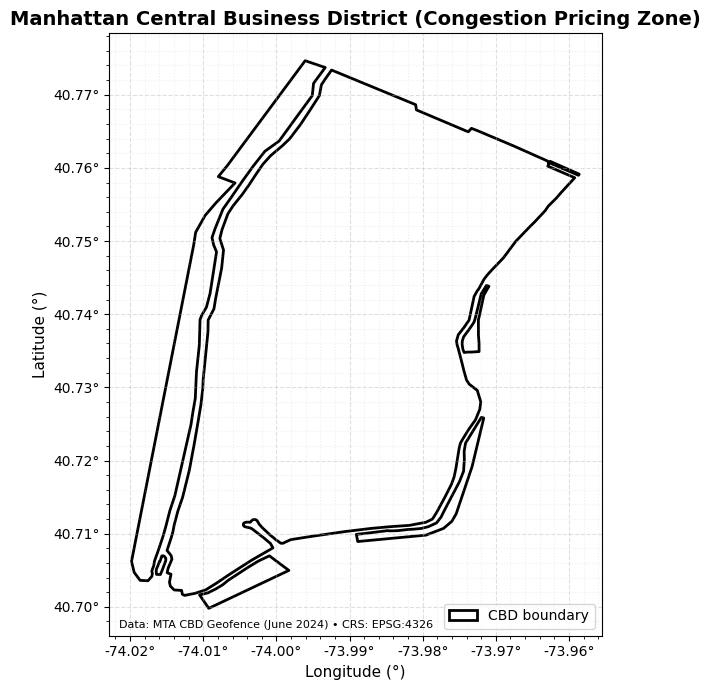

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, AutoMinorLocator
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

cbd = gpd.read_file(CBD_GEOJSON).to_crs(epsg=4326)
cbd1 = cbd.dissolve()

# bounds for consistent map view
minx, miny, maxx, maxy = cbd1.total_bounds
dx, dy = (maxx-minx)*0.05, (maxy-miny)*0.05
xlim = (minx-dx, maxx+dx)
ylim = (miny-dy, maxy+dy)

fig, ax = plt.subplots(figsize=(7,7))

# CBD outline
cbd1.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2, label="CBD boundary")


ax.set_xlim(xlim); ax.set_ylim(ylim)
ax.set_aspect("equal", adjustable="box")

# Title + labels
ax.set_title("Manhattan Central Business District (Congestion Pricing Zone)", fontsize=14, fontweight="bold")
ax.set_xlabel("Longitude (°)", fontsize=11)
ax.set_ylabel("Latitude (°)", fontsize=11)

# Degree tick formatting
deg = u"\N{DEGREE SIGN}"
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.2f}{deg}"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{y:.2f}{deg}"))

# Minor ticks + light grid
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(True, which="major", linestyle="--", alpha=0.4)
ax.grid(True, which="minor", linestyle=":",  alpha=0.2)

# Legend + small caption
ax.legend(handles=[Patch(facecolor="none", edgecolor="black", linewidth=2, label="CBD boundary")],
          loc="lower right", frameon=True)
ax.annotate("Data: MTA CBD Geofence (June 2024) • CRS: EPSG:4326",
            xy=(0.02, 0.02), xycoords="axes fraction", fontsize=8, va="center_baseline")

plt.tight_layout()
plt.show()

###Load ACE violations & keep only those inside CBD

All violations: 3778568 | CBD-only: 419576


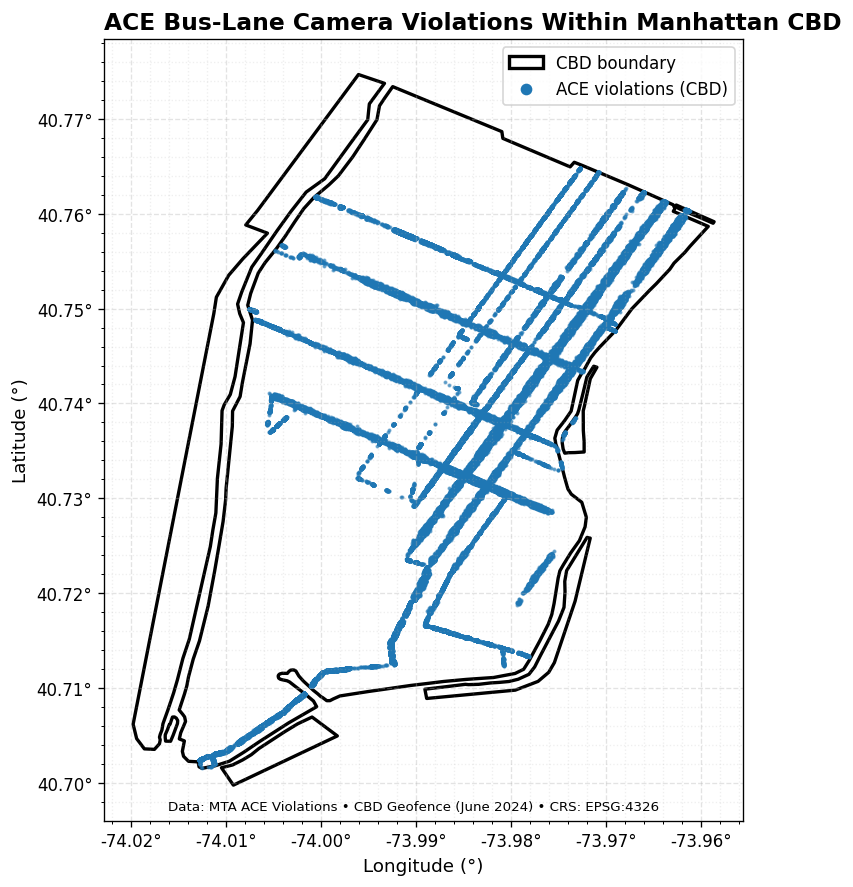

In [ ]:
viol = pd.read_csv(VIOL_CSV)
# geo-enable
viol_gdf = gpd.GeoDataFrame(
    viol,
    geometry=gpd.points_from_xy(viol["Violation Longitude"], viol["Violation Latitude"]),
    crs="EPSG:4326"
)
# spatial filter: only CBD points
viol_cbd = gpd.sjoin(viol_gdf, cbd1, how="inner", predicate="within").drop(columns=["index_right"])

# Inspect
print("All violations:", len(viol_gdf), "| CBD-only:", len(viol_cbd))

# quick map
n_all = len(viol_gdf)
n_cbd = len(viol_cbd)

dt = pd.to_datetime(viol_cbd["First Occurrence"], errors="coerce", utc=True)
if dt.notna().any():
    dt_ny = dt.dt.tz_convert("America/New_York")
    span = f"{dt_ny.min().date()}–{dt_ny.max().date()}"
else:
    span = ""

# ---- plot ----
fig, ax = plt.subplots(figsize=(7.5,7.5), dpi=120)

# boundary first (so it doesn’t cover points)
cbd1.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2, label="CBD boundary")

# CBD-only violations
viol_cbd.plot(ax=ax, markersize=2, alpha=0.55, color="#1f77b4", label="ACE violations (CBD)")

ax.set_xlim(xlim); ax.set_ylim(ylim)
ax.set_aspect("equal", adjustable="box")

# title + subtitle with counts
title = "ACE Bus-Lane Camera Violations Within Manhattan CBD"
ax.set_title(f"{title}", fontsize=14, fontweight="bold", loc="left")

# axis labels + pretty degree ticks
deg = u"\N{DEGREE SIGN}"
ax.set_xlabel(f"Longitude ({deg})", fontsize=11)
ax.set_ylabel(f"Latitude ({deg})", fontsize=11)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.2f}{deg}"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{y:.2f}{deg}"))

# minor ticks + light grid
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(True, which="major", linestyle="--", alpha=0.35)
ax.grid(True, which="minor", linestyle=":",  alpha=0.20)

# legend + caption

legend_elems = [
    Patch(facecolor="none", edgecolor="black", linewidth=2, label="CBD boundary"),
    Line2D([0],[0], marker="o", linestyle="none", markerfacecolor="#1f77b4",
           markeredgecolor="#1f77b4", markersize=6, label="ACE violations (CBD)"),
]
ax.legend(handles=legend_elems, loc="upper right", frameon=True)
ax.annotate("Data: MTA ACE Violations • CBD Geofence (June 2024) • CRS: EPSG:4326",
            xy=(0.1, 0.02), xycoords="axes fraction", fontsize=8, va="center_baseline")

plt.tight_layout()
plt.show()

###Limit to ACE-enforced routes & count CBD violations by route

In [ ]:
enforced = pd.read_csv(ROUTES_CSV)  # ['Route','Program','Implementation Date']
enforced["Route"] = enforced["Route"].astype(str).str.strip().str.upper()

# count CBD violations by route
viol_cbd["Bus Route ID"] = viol_cbd["Bus Route ID"].astype(str).str.strip().str.upper()
viol_counts = (
    viol_cbd.groupby("Bus Route ID").size().reset_index(name="Violation Count")
)

# keep only enforced routes
viol_counts_enf = viol_counts.merge(enforced[["Route"]], left_on="Bus Route ID", right_on="Route", how="inner")
viol_counts_enf = viol_counts_enf.drop(columns=["Route"]).sort_values("Violation Count", ascending=False)

print("Enforced routes with CBD violations:", len(viol_counts_enf))
viol_counts_enf.head(10)

Enforced routes with CBD violations: 12


,Bus Route ID,Violation Count
3,M15+,250898
4,M15+,250898
2,M14+,63859
1,M14+,63859
0,M101,48268
8,M34+,23615
9,M34+,23615
6,M23+,15993
7,M23+,15993
5,M2,6868


###Establish baseline speeds in CBD on ACE routes

In [ ]:
speeds = pd.read_csv(SPEEDS_CSV)  # headers you provided
speeds["Route ID"] = speeds["Route ID"].astype(str).str.strip().str.upper()

# Manhattan only
speeds_m = speeds[speeds["Borough"].str.upper()=="MANHATTAN"].copy()

# baseline by route (for enforced routes we observed in CBD)
baseline_speeds = (
    speeds_m[speeds_m["Route ID"].isin(viol_counts_enf["Bus Route ID"])]
    .groupby("Route ID", as_index=False)["Average Road Speed"].mean()
    .rename(columns={"Average Road Speed":"Avg Speed (mph)"})
)

baseline_speeds.sort_values("Avg Speed (mph)").head(10)

,Route ID,Avg Speed (mph)
6,M42,5.482560
4,M34+,5.594312
3,M23+,6.269037
5,M4,6.349652
0,M101,7.388023
2,M2,8.075144
1,M15+,8.750157


###Map real route lines inside CBD to color lines by violations/speed

In [74]:
# --- read & prep shapes ---
shapes_txt = pd.read_csv(
    SHAPES_TXT,
    usecols=["shape_id", "shape_pt_lat", "shape_pt_lon", "shape_pt_sequence"]
)

# make sure types are numeric & ordered
shapes_txt[["shape_pt_lon","shape_pt_lat","shape_pt_sequence"]] = (
    shapes_txt[["shape_pt_lon","shape_pt_lat","shape_pt_sequence"]]
      .apply(pd.to_numeric, errors="coerce")
)
shapes_sorted = shapes_txt.dropna(subset=["shape_pt_lon","shape_pt_lat","shape_pt_sequence"]) \
                          .sort_values(["shape_id","shape_pt_sequence"])

# --- build one LineString per shape_id
def make_line(g):
    coords = g[["shape_pt_lon","shape_pt_lat"]].to_numpy()
    return LineString(coords) if len(coords) >= 2 else None

lines = (
    shapes_sorted
      .groupby("shape_id")[["shape_pt_lon","shape_pt_lat"]]
      .apply(make_line)                               # grouping col is not passed to the func
      .reset_index(name="geometry")
      .dropna(subset=["geometry"])
)

routes_gdf = gpd.GeoDataFrame(lines, geometry="geometry", crs="EPSG:4326")

# Attach public_id (route_id-like)
routes_named = routes_gdf.merge(shape_to_public[["shape_id","public_id"]], on="shape_id", how="left")
routes_named["public_id"] = routes_named["public_id"].fillna("")

# Keep Manhattan routes by naming convention (IDs start with 'M'); EXCLUDES M100 if you want
routes_M = routes_named[routes_named["public_id"].str.startswith("M")].copy()
routes_M = routes_M[routes_M["public_id"] != "M100"]

print("Unique M routes in GTFS:", routes_M["public_id"].nunique())

# Clip to CBD & dissolve to one line per route
if len(routes_M):
    routes_in_cbd = gpd.overlay(routes_M, cbd1, how="intersection").set_crs("EPSG:4326", allow_override=True)
    routes_in_cbd_1 = routes_in_cbd.dissolve(by="public_id", as_index=False)
    print("Routes with CBD geometry:", len(routes_in_cbd_1))
else:
    routes_in_cbd_1 = gpd.GeoDataFrame(columns=["public_id","geometry"], geometry="geometry", crs="EPSG:4326")

Unique M routes in GTFS: 41
Routes with CBD geometry: 30


####Visual 1 — Focused CBD map with routes colored by violations


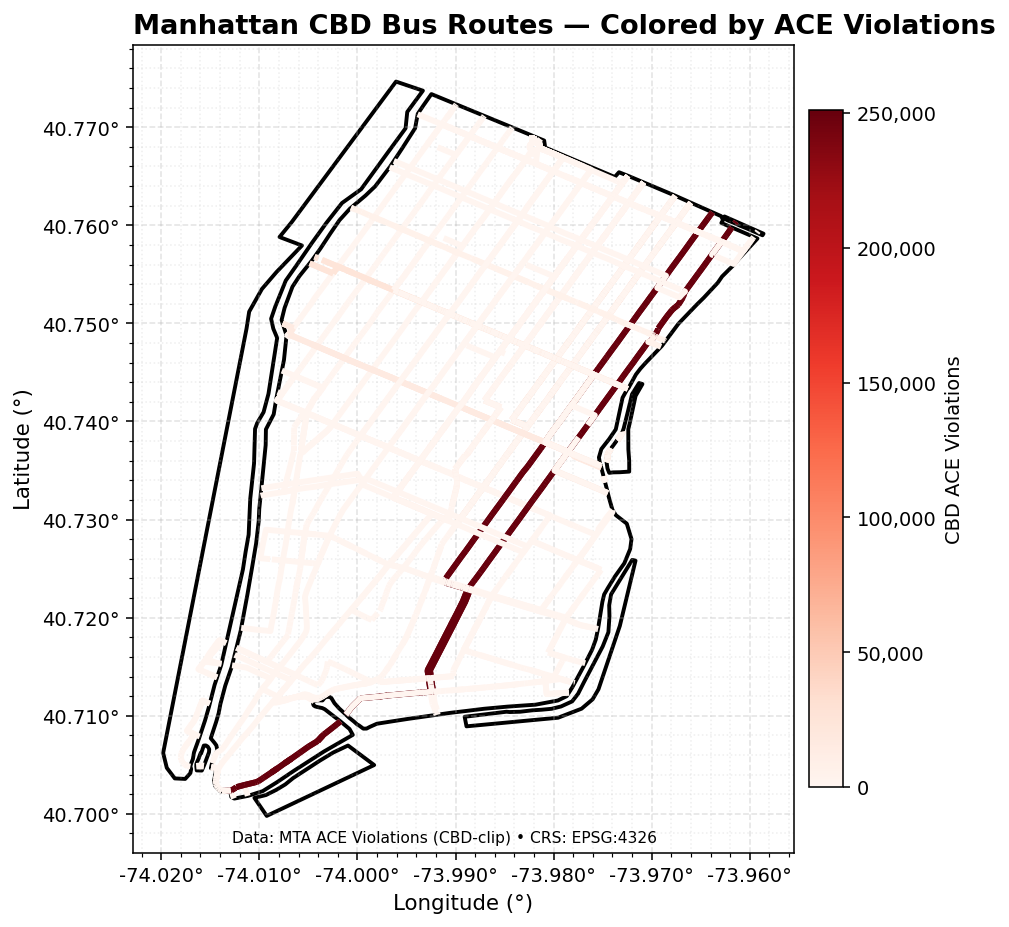

In [ ]:
if len(routes_in_cbd_1):
    # join counts (ACE uses M14+ etc.; if your GTFS uses M14-SBS, map '+' -> '-SBS' instead)
    counts_for_join = viol_counts_enf.rename(columns={"Bus Route ID":"public_id"}).copy()

    routes_viol = routes_in_cbd_1.merge(counts_for_join, on="public_id", how="left")
    routes_viol["Violation Count"] = routes_viol["Violation Count"].fillna(0).astype(int)

    fig, ax = plt.subplots(figsize=(7,7), dpi=140)

    # CBD outline
    cbd1.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2, label="CBD boundary")

    # Routes colored by violations
    m = routes_viol.plot(
        ax=ax,
        column="Violation Count",
        cmap="Reds",
        linewidth=3,
        legend=True,
        legend_kwds={"label":"CBD ACE Violations", "shrink":0.8, "pad":0.02}
    )

    # View + aspect
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    ax.set_aspect("equal", adjustable="box")

    # Title only (no subtitle)
    ax.set_title("Manhattan CBD Bus Routes — Colored by ACE Violations",
                fontsize=14, fontweight="bold", loc="left")

    # Axis labels + degree formatting
    deg = u"\N{DEGREE SIGN}"
    ax.set_xlabel(f"Longitude ({deg})", fontsize=11)
    ax.set_ylabel(f"Latitude ({deg})", fontsize=11)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.3f}{deg}"))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{y:.3f}{deg}"))

    # Minor ticks + light grid
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(True, which="major", linestyle="--", alpha=0.35)
    ax.grid(True, which="minor", linestyle=":",  alpha=0.20)

    # Colorbar tick formatting (1,000 separators)
    cbar_ax = m.figure.axes[-1]
    cbar_ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{int(v):,}"))

    # Optional small caption (keep/remove as you like)
    ax.annotate("Data: MTA ACE Violations (CBD-clip) • CRS: EPSG:4326",
                xy=(0.15, 0.02), xycoords="axes fraction", fontsize=8, va="center_baseline")

    plt.tight_layout()
    plt.show()

else:
    print("GTFS lacks M-route shapes; skipping line-map")



###Visual 2 — Top routes by CBD violations (bar chart)

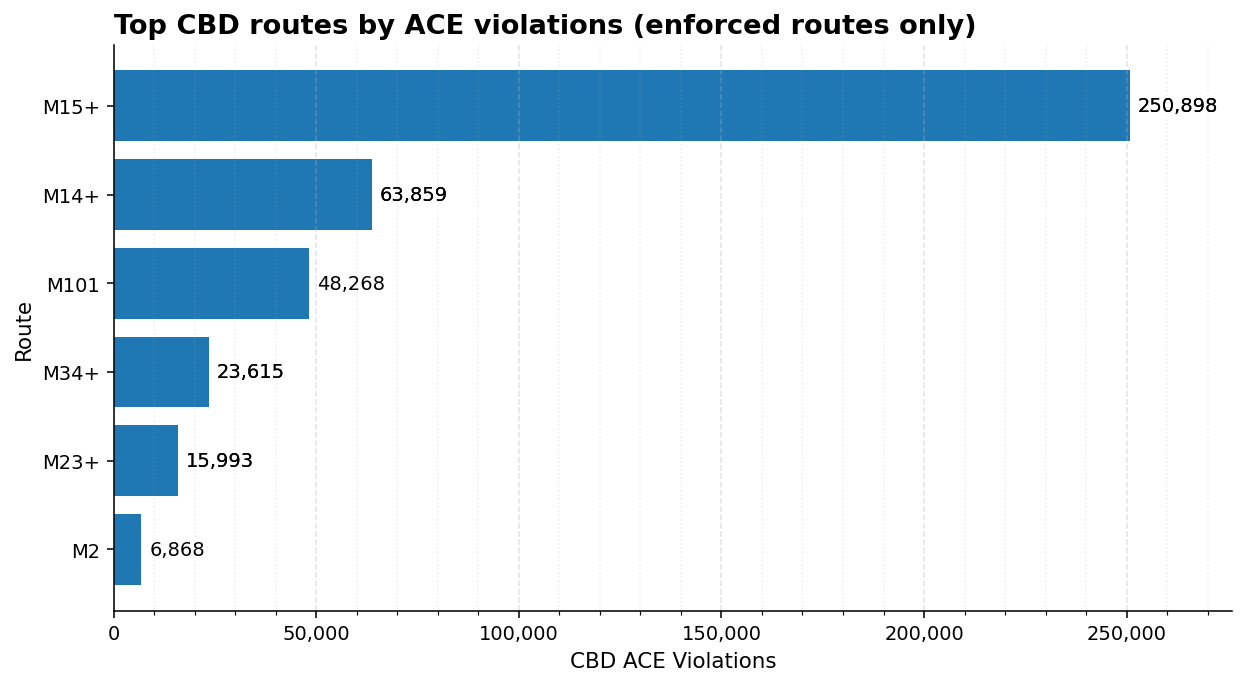

In [ ]:
# sorted top N (defensive)
topN = 10
top_viol = (viol_counts_enf
            .sort_values("Violation Count", ascending=False)
            .head(topN)
            .copy())

y = top_viol["Bus Route ID"].astype(str).values
x = top_viol["Violation Count"].values

fig, ax = plt.subplots(figsize=(9,5), dpi=140)

# draw bars and keep the container
bars = ax.barh(y, x, color="#1f77b4")

# biggest at top
ax.invert_yaxis()

# add value labels exactly at bar ends (no misalignment)
ax.bar_label(
    bars,
    labels=[f"{v:,.0f}" for v in x],
    label_type="edge",   # places at bar edge
    padding=4,           # a few px to the right of the bar
    fontsize=10
)

# give labels breathing room
ax.set_xlim(0, x.max() * 1.10)

# styling
ax.set_title("Top CBD routes by ACE violations (enforced routes only)",
             fontsize=14, fontweight="bold", loc="left")
ax.set_xlabel("CBD ACE Violations", fontsize=11)
ax.set_ylabel("Route", fontsize=11)

ax.xaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{int(v):,}"))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.grid(True, which="major", axis="x", linestyle="--", alpha=0.35)
ax.grid(True, which="minor", axis="x", linestyle=":",  alpha=0.20)

for spine in ("top","right"):
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

###Visual 3 — Routes colored by average speed

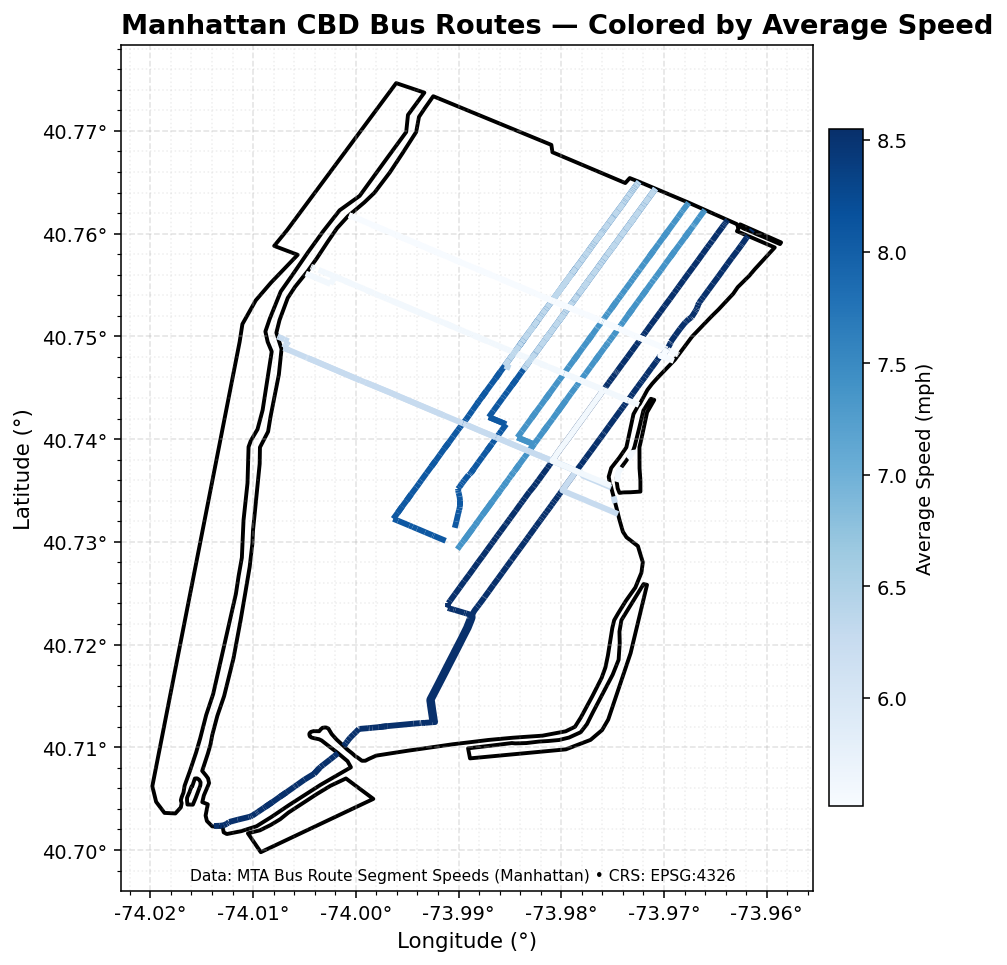

In [ ]:
if len(routes_in_cbd_1):
    # join speeds
    routes_speed = routes_in_cbd_1.merge(
        baseline_speeds, left_on="public_id", right_on="Route ID", how="left"
    )

    # pick a sensible color range (robust to outliers)
    s = routes_speed["Avg Speed (mph)"].dropna()
    if s.empty:
        vmin, vmax = 5.0, 12.0
    else:
        vmin, vmax = s.quantile(0.05), s.quantile(0.95)  # trim extremes

    fig, ax = plt.subplots(figsize=(7,7), dpi=140)

    # CBD outline
    cbd1.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2, label="CBD boundary")

    # Routes colored by average speed
    m = routes_speed.plot(
        ax=ax,
        column="Avg Speed (mph)",
        cmap="Blues",
        linewidth=3,
        legend=True,
        vmin=vmin, vmax=vmax,
        legend_kwds={"label":"Average Speed (mph)", "shrink":0.8, "pad":0.02}
    )

    # view + aspect
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    ax.set_aspect("equal", adjustable="box")

    # title only
    ax.set_title("Manhattan CBD Bus Routes — Colored by Average Speed",
                 fontsize=14, fontweight="bold", loc="left")

    # axis labels + degree ticks
    deg = u"\N{DEGREE SIGN}"
    ax.set_xlabel(f"Longitude ({deg})", fontsize=11)
    ax.set_ylabel(f"Latitude ({deg})", fontsize=11)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.2f}{deg}"))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{y:.2f}{deg}"))

    # minor ticks + light grid
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(True, which="major", linestyle="--", alpha=0.35)
    ax.grid(True, which="minor", linestyle=":",  alpha=0.20)

    # colorbar tick formatting (one decimal mph)
    cbar_ax = m.figure.axes[-1]
    cbar_ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.1f}"))

    # optional caption
    ax.annotate("Data: MTA Bus Route Segment Speeds (Manhattan) • CRS: EPSG:4326",
                xy=(0.1, 0.02), xycoords="axes fraction", fontsize=8, va="center_baseline")

    plt.tight_layout()
    plt.show()

else:
    # ---- fallback: speed bars for the same top-violation routes ----
    sp = baseline_speeds[baseline_speeds["Route ID"].isin(top_viol["Bus Route ID"])].copy()
    sp = top_viol[["Bus Route ID"]].merge(sp, left_on="Bus Route ID", right_on="Route ID", how="left")

    fig, ax = plt.subplots(figsize=(8,5), dpi=140)
    bars = ax.barh(sp["Bus Route ID"], sp["Avg Speed (mph)"], color="#1f77b4")

    # biggest on top
    ax.invert_yaxis()

    # value labels at bar edge
    ax.bar_label(
        bars,
        labels=[f"{v:.1f}" if pd.notna(v) else "" for v in sp["Avg Speed (mph)"]],
        label_type="edge", padding=4, fontsize=10
    )
    ax.set_xlim(0, max(1.0, (sp["Avg Speed (mph)"].max() or 10) * 1.15))

    ax.set_title("Average speed on top CBD-violation routes (Manhattan)",
                 fontsize=14, fontweight="bold", loc="left")
    ax.set_xlabel("Avg Speed (mph)", fontsize=11)
    ax.set_ylabel("Route", fontsize=11)

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(True, which="major", axis="x", linestyle="--", alpha=0.35)
    ax.grid(True, which="minor", axis="x", linestyle=":",  alpha=0.20)

    for spine in ("top","right"):
        ax.spines[spine].set_visible(False)

    plt.show()

###Visual 4 — Before vs After (predictive) for key CBD routes
“before/after” visualization; we model a conservative uplift (e.g., +15%)

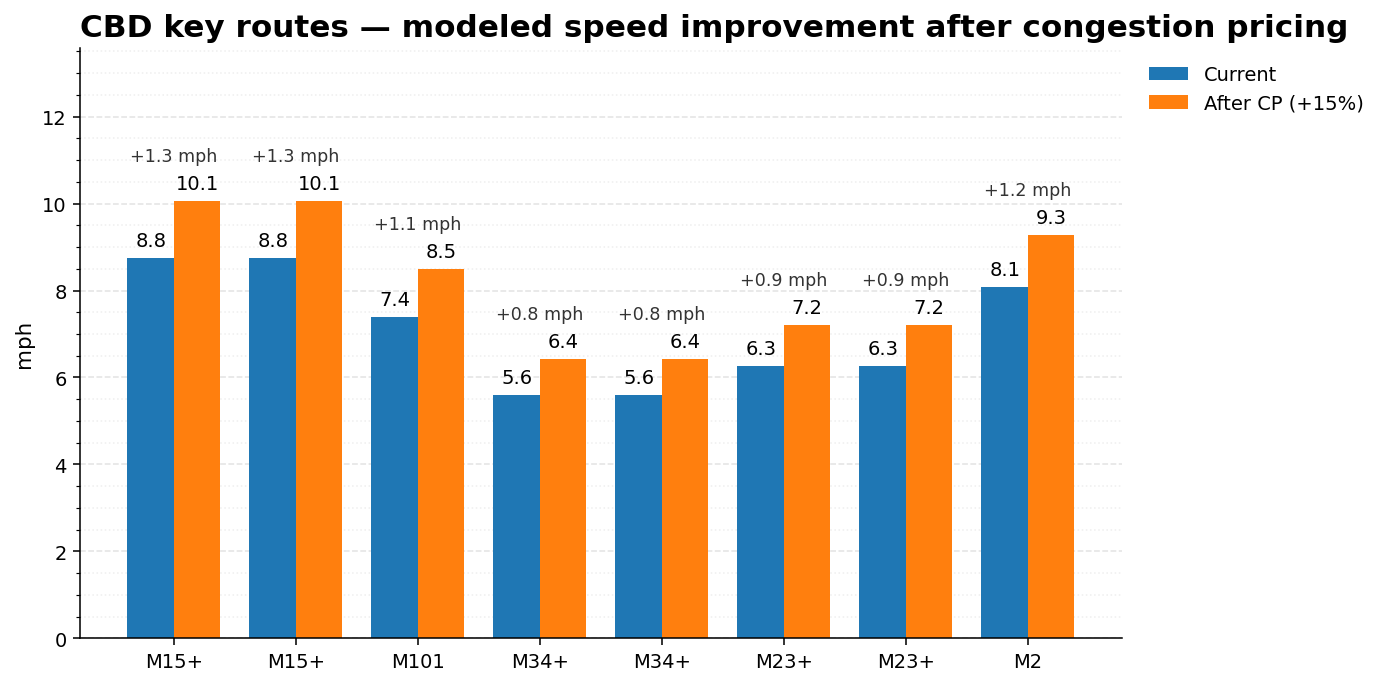

In [ ]:
uplift = 0.15  # 15% scenario

# build the data the same way you already did
top_for_model = (
    top_viol.merge(baseline_speeds, left_on="Bus Route ID", right_on="Route ID", how="left")
            .dropna(subset=["Avg Speed (mph)"])
            .copy()
)
routes  = top_for_model["Bus Route ID"].to_list()
current = top_for_model["Avg Speed (mph)"].to_numpy()
after   = current * (1 + uplift)

x = np.arange(len(routes))
w = 0.38

fig, ax = plt.subplots(figsize=(10,5), dpi=140)

bars_curr  = ax.bar(x - w/2, current, width=w, label="Current",              color="#1f77b4", zorder=2)
bars_after = ax.bar(x + w/2, after,   width=w, label=f"After CP (+{int(uplift*100)}%)", color="#ff7f0e", zorder=2)

# --- headroom so labels sit above bars cleanly ---
ymax = max(after.max(), current.max())
ax.set_ylim(0, ymax * 1.35)   # more top space
ax.margins(y=0.05)

# --- labels JUST ABOVE each bar (no overlap with bar tops) ---
ax.bar_label(bars_curr,  labels=[f"{v:.1f}" for v in current], padding=4, fontsize=10, clip_on=False)
ax.bar_label(bars_after, labels=[f"{v:.1f}" for v in after],   padding=4, fontsize=10, clip_on=False)

# --- show +Δ mph centered between each pair (won't collide with bar labels) ---
show_delta = True
if show_delta:
    bump = 0.06 * ax.get_ylim()[1]  # vertical offset above the taller bar
    for xi, c, a in zip(x, current, after):
        ax.text(xi, max(c, a) + bump, f"+{(a-c):.1f} mph",
                ha="center", va="bottom", fontsize=9, color="#333")

# styling
ax.set_xticks(x); ax.set_xticklabels(routes)
ax.set_ylabel("mph", fontsize=11)
ax.set_title("CBD key routes — modeled speed improvement after congestion pricing",
             fontsize=16, fontweight="bold", loc="left")
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(True, which="major", axis="y", linestyle="--", alpha=0.35)
ax.grid(True, which="minor", axis="y", linestyle=":",  alpha=0.20)
for s in ("top","right"): ax.spines[s].set_visible(False)

ax.legend(loc="upper left", bbox_to_anchor=(1.01, 1), frameon=False)
plt.tight_layout()
plt.show()
